In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import pack_vis_sol
import pack_dynamics
import copy
import time
import pack_ga3
import pack_io
from IPython.display import HTML, display, clear_output


Detected environment: local


In [2]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
#kgs.enable_module_profiling(kgs)
import pack_ga3
import pack_runner
fastMode = False
kgs.debugging_mode = 1

runner = pack_ga3.baseline_symmetry_180_tesselated()
#runner.ga.ga_base.initializer.ref_sol_crystal_type = 'Perfect dimer'
#runner.ga.ga_base.initializer.ref_sol_axis1_offset = 0.
runner.ga.ga_base.initializer.ref_sol_axis2_offset = lambda r:0.5

runner.ga.N = 2
runner.ga.ga_base.N_trees_to_do = 100
runner.n_generations = 0
runner.diagnostic_plot = True
runner.seed = 1
runner.plot_every = 1
runner.ga.do_legalize = False

self = runner
if self._generator is None:
    self._generator = cp.random.default_rng(seed=self.seed)

self.ga.fitness_cost = self.fitness_cost
self.ga.seed = self.seed

# Initialize
self.ga.initialize(self._generator)
self.ga.reset(self._generator)
#self._relax(self.ga.get_list_for_simulation())    
self.ga.score(self._generator, register_best=True)

init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved_40747.cu -o /mnt/d//packing/temp/pack_cuda_crystal_40747.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 8.815 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas 

Captured 80 figures
Saved animated GIF to /mnt/d//packing/temp/relaxation_animation.gif


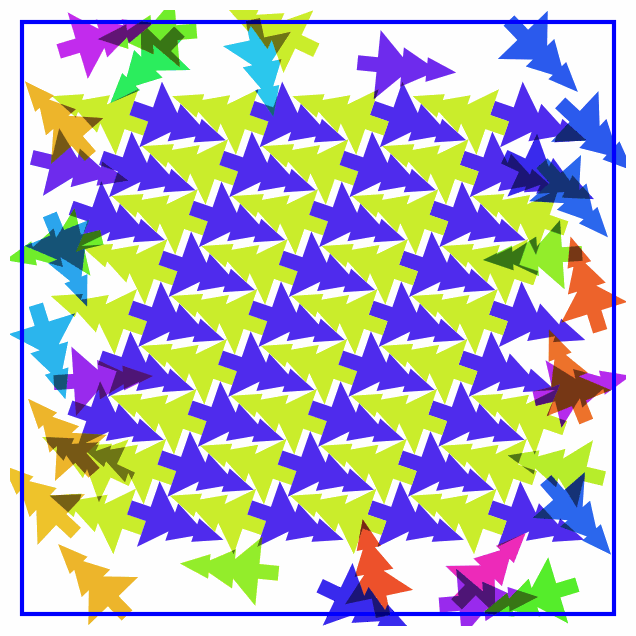

In [11]:
# Run optimization with figure capture
import io
from PIL import Image
from IPython.display import Image as IPImage

sol = copy.deepcopy(runner.ga.champions[0].phenotype)
relaxers = runner.rough_relaxers + runner.fine_relaxers

# Collect all figures by enabling store_figures mode
all_figures = []
for relaxer in relaxers[:1]:
    relaxer.plot_interval = 1
    relaxer.store_figures = True
    relaxer._stored_figures = []  # Reset stored figures
    sol = relaxer.run_simulation(sol)
    all_figures.extend(relaxer._stored_figures)
    plt.close('all')  # Clean up

print(f"Captured {len(all_figures)} figures")

# Convert figures to PIL Images
images = []
for fig in all_figures:
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    images.append(Image.open(buf).copy())
    buf.close()
    plt.close(fig)

# Save as animated GIF
if images:
    gif_path = kgs.temp_dir+'relaxation_animation.gif'
    durations = [1000] + [80] * (len(images) - 2) + [1000]  # 5x longer for first frame
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=durations,
        loop=0  # 0 = loop forever
    )
    print(f"Saved animated GIF to {gif_path}")
    
    # Display the GIF
    display(IPImage(filename=gif_path))
else:
    print("No figures were captured during optimization.")

In [9]:
# Speed test
sol_big = copy.deepcopy(sol)
sol_big.select_ids([0]*100000)
for relaxer in relaxers:
    relaxer.plot_interval = None    
    sol_big = relaxer.run_simulation(sol_big)